In [9]:
import os
import joblib
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [10]:
# Create directories for saving artifacts
os.makedirs("models", exist_ok=True)
os.makedirs("forecasts", exist_ok=True)

In [11]:
# ======================
# 1. Fetch Historical Data
# ======================
assets = ['TSLA', 'BND', 'SPY']
print("Downloading data from Yahoo Finance...")
data = {}
for asset in assets:
    df = yf.download(asset, start="2015-01-01", end="2025-01-31")
    data[asset] = df['Close']  # Extract closing prices
    print(f"{asset} data shape: {data[asset].shape}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

TSLA data shape: (2535, 1)



[*********************100%***********************]  1 of 1 completed

BND data shape: (2535, 1)
SPY data shape: (2535, 1)


In [12]:
# ======================
# 2. Preprocess Data
# ======================
def preprocess_series(series):
    """Handle missing values and set frequency"""
    series = series.asfreq('B')  # Business days
    series = series.ffill()      # Forward-fill missing values
    series.index.freq = 'B'      # Explicitly set frequency
    return series

print("\nPreprocessing data...")
for asset in assets:
    data[asset] = preprocess_series(data[asset])
    print(f"{asset} missing values after processing: {data[asset].isnull().sum()}")


Preprocessing data...
TSLA missing values after processing: Ticker
TSLA    0
dtype: int64
BND missing values after processing: Ticker
BND    0
dtype: int64
SPY missing values after processing: Ticker
SPY    0
dtype: int64


In [13]:
# 3. Train SARIMA Models
# ======================
def train_sarima(series, order=(4,1,0), seasonal_order=(1,1,1,5)):
    """Train and save SARIMA model"""
    model = SARIMAX(series,
                   order=order,
                   seasonal_order=seasonal_order,
                   enforce_stationarity=False)
    model_fit = model.fit(disp=False)
    return model_fit

print("\nTraining models...")
models = {}
for asset in assets:
    print(f"Training {asset} model...")
    models[asset] = train_sarima(data[asset])
    joblib.dump(models[asset], f"models/{asset}_sarima.pkl")
    print(f"{asset} model AIC: {models[asset].aic:.2f}")


Training models...
Training TSLA model...
TSLA model AIC: 17032.24
Training BND model...
BND model AIC: -134.00
Training SPY model...
SPY model AIC: 13949.54


In [15]:
# 4. Generate Forecasts
# ======================
forecast_months = 6
business_days = forecast_months * 21  # Approx 21 trading days/month

forecasts = {}
for asset in assets:
    print(f"\nForecasting {asset}...")
    # Load trained model
    model = joblib.load(f"models/{asset}_sarima.pkl")
    
    # Generate forecast with 95% CI
    forecast = model.get_forecast(steps=business_days)
    forecast_df = pd.DataFrame({
        'Date': forecast.predicted_mean.index,
        'Forecast': forecast.predicted_mean.values,
        'CI_Lower': forecast.conf_int().iloc[:,0],
        'CI_Upper': forecast.conf_int().iloc[:,1]
    }).set_index('Date')
    
    # Save forecasts
    forecast_df.to_csv(f"forecasts/{asset}_forecast.csv")
    forecasts[asset] = forecast_df
    print(f"{asset} forecast saved!")



Forecasting TSLA...
TSLA forecast saved!

Forecasting BND...
BND forecast saved!

Forecasting SPY...
SPY forecast saved!


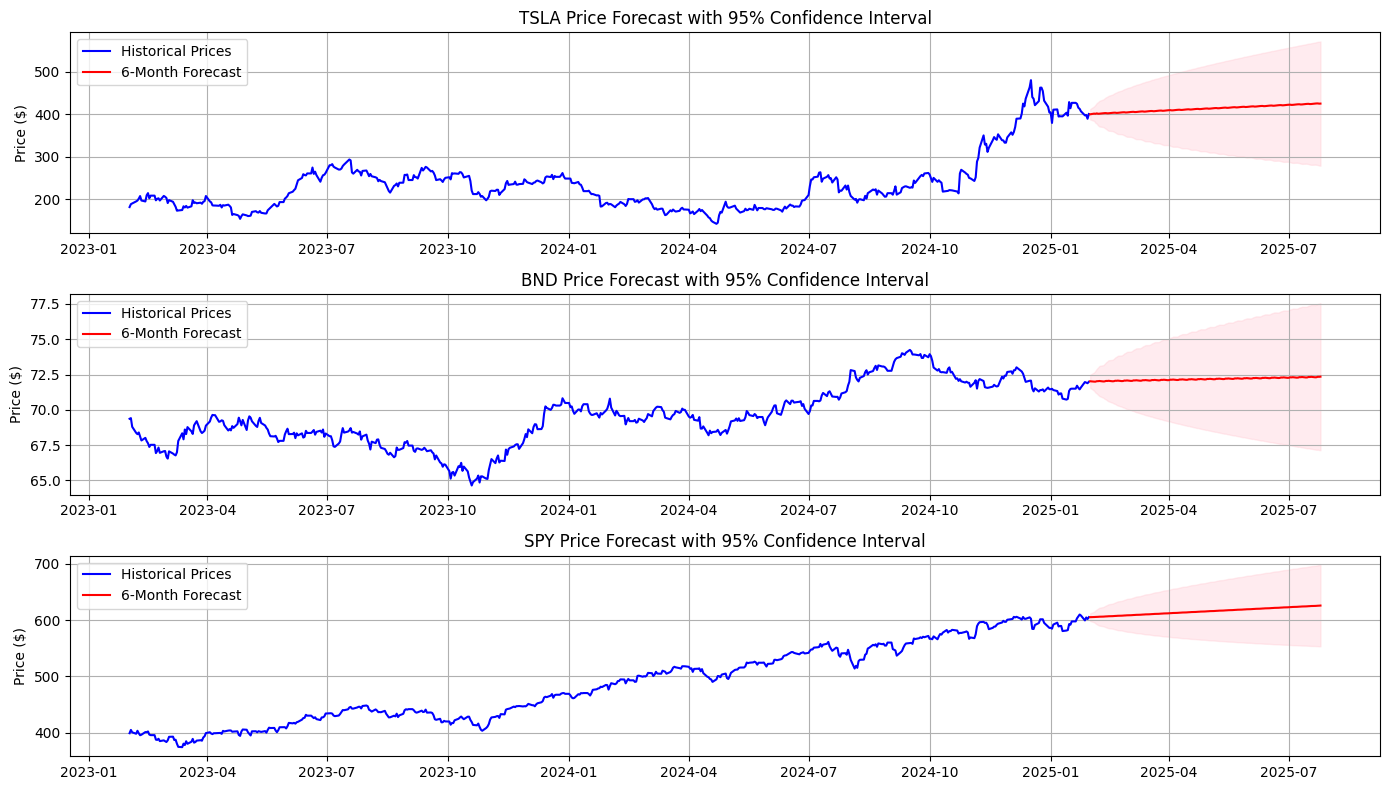

In [16]:
# 5. Visualize Forecasts
# ======================
plt.figure(figsize=(14, 8))
for idx, asset in enumerate(assets, 1):
    plt.subplot(3, 1, idx)
    
    # Historical data (last 2 years for context)
    historical = data[asset].loc['2023-02-01':]
    plt.plot(historical, label='Historical Prices', color='blue')
    
    # Forecast
    forecast = forecasts[asset]
    plt.plot(forecast.index, forecast['Forecast'], 
             label='6-Month Forecast', color='red')
    
    # Confidence interval
    plt.fill_between(forecast.index,
                     forecast['CI_Lower'],
                     forecast['CI_Upper'],
                     color='pink', alpha=0.3)
    
    plt.title(f"{asset} Price Forecast with 95% Confidence Interval")
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig('forecasts/combined_forecasts.png', dpi=300)
plt.show()
